## Output:en (grafer) kan se lite konstigt ut eftersom jag har hoppat mellan laptop och PC, så följ screenshotsen istället där jag besvarar frågor för korrekt output

In [ ]:
import cv2
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Activation,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Rescaling,
    GlobalAveragePooling2D
)
from keras.models import Sequential
import matplotlib.pyplot as plt
from loguru import logger
from tensorflow.keras import regularizers, layers, keras, optimizers
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small, VGG16, MobileNet
from tensorflow.keras.models import Model
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# for swapping between laptop and PC
flowers_desktop = "E:\\Github sparade filer\\Deep-Learning\\data\MNIST\\raw\\flowers"
flowers_laptop = "C:\\Github\\Deep-Learning\\data\\MNIST\\raw\\flowers"
data = []
labels = []

for folder in os.listdir(flowers_desktop):  # loops through folders in flowers folders
    logger.info(f"processing folder: {folder}")
    for file in os.listdir(os.path.join(flowers_desktop, folder)):  # Loops through each individual picture in each folder
        if file.endswith("jpg"):  # only jpgs
            labels.append(folder)  # extracting flower names and put them in labels list
            img = cv2.imread(os.path.join(flowers_desktop, folder, file))  # reads the image
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # since they're colored images
            im = cv2.resize(img_rgb, (128, 128))  # resizes the image because they are all different sizes
            data.append(im)  # appends image to data folder
        else:
            logger.debug(f"Skipping non-jpg file: {file}")

logger.info("finished processing images")

logger.info("converting data and labels to numpy arrays")
data_arr = np.array(data)
label_arr = np.array(labels)

logger.info("encoding labels and normalizing data")
encoder = LabelEncoder()  # converts labels to numbers
y = encoder.fit_transform(labels)  # fits labels and return encoded labels
y = to_categorical(y, 5)
X = data_arr / 255  # normalize data

logger.info("done.")

2023-12-18 18:18:40.406 | INFO     | __main__:<cell line: 7>:7 - starting to process folders...
2023-12-18 18:18:40.407 | INFO     | __main__:<cell line: 9>:10 - processing folder: daisy


2023-12-18 18:18:41.845 | INFO     | __main__:<cell line: 9>:10 - processing folder: dandelion
2023-12-18 18:18:43.817 | INFO     | __main__:<cell line: 9>:10 - processing folder: rose
2023-12-18 18:18:45.244 | INFO     | __main__:<cell line: 9>:10 - processing folder: sunflower
2023-12-18 18:18:46.935 | INFO     | __main__:<cell line: 9>:10 - processing folder: tulip
2023-12-18 18:18:48.955 | INFO     | __main__:<cell line: 21>:21 - finished processing images
2023-12-18 18:18:48.956 | INFO     | __main__:<cell line: 23>:23 - converting data and labels to numpy arrays
2023-12-18 18:18:49.033 | INFO     | __main__:<cell line: 27>:27 - encoding labels and normalizing data
2023-12-18 18:18:49.637 | INFO     | __main__:<cell line: 33>:33 - done.


In [20]:
folder_counts = {}  # indices can't be strings for lists, therefore dict

# loops through each category in flowers folder like above
for folder in os.listdir(flowers_desktop):
    folder_path = os.path.join(flowers_desktop, folder)
    if os.path.isdir(folder_path):
        # counts how many images there are in each folder (list comprehension)
        count = len([file for file in os.listdir(folder_path) if file.endswith(".jpg")]) 
        folder_counts[folder] = count

        logger.info(f"{folder}: {count}")

logger.info("done")

2023-12-18 18:21:05.792 | INFO     | __main__:<cell line: 4>:12 - daisy: 764
2023-12-18 18:21:05.794 | INFO     | __main__:<cell line: 4>:12 - dandelion: 1052
2023-12-18 18:21:05.795 | INFO     | __main__:<cell line: 4>:12 - rose: 784
2023-12-18 18:21:05.797 | INFO     | __main__:<cell line: 4>:12 - sunflower: 733
2023-12-18 18:21:05.798 | INFO     | __main__:<cell line: 4>:12 - tulip: 984
2023-12-18 18:21:05.799 | INFO     | __main__:<cell line: 14>:14 - done


In [8]:
from sklearn.model_selection import train_test_split

# train val split 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# simple data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

def base_model():
    model = Sequential()
    model.add(data_augmentation) # data augmentation before convolutional layers
    
    # 4 convolutional layers followed by pooling layer
    model.add(Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten()) # transforms from multi-dimension to 1D
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))) # FC layer
    model.add(Dropout(0.3)) # randomly sets 30% to 0
    model.add(Dense(5, activation="softmax")) # output layer
    return model

CNN_model = base_model()
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20


108/108 [==============================] - 13s 100ms/step - loss: 2.2543 - accuracy: 0.2951 - val_loss: 1.4790 - val_accuracy: 0.3727
Epoch 2/20
108/108 [==============================] - 10s 96ms/step - loss: 1.3268 - accuracy: 0.4613 - val_loss: 1.1958 - val_accuracy: 0.5359
Epoch 3/20
108/108 [==============================] - 10s 92ms/step - loss: 1.2158 - accuracy: 0.5224 - val_loss: 1.1134 - val_accuracy: 0.5949
Epoch 4/20
108/108 [==============================] - 10s 97ms/step - loss: 1.1380 - accuracy: 0.5760 - val_loss: 1.1136 - val_accuracy: 0.6123
Epoch 5/20
108/108 [==============================] - 10s 90ms/step - loss: 1.0994 - accuracy: 0.5908 - val_loss: 1.1079 - val_accuracy: 0.6215
Epoch 6/20
108/108 [==============================] - 10s 90ms/step - loss: 1.0756 - accuracy: 0.6012 - val_loss: 1.0442 - val_accuracy: 0.6157
Epoch 7/20
108/108 [==============================] - 9s 87ms/step - loss: 1.0428 - accuracy: 0.6255 - val_loss: 1.0006 - val_accurac

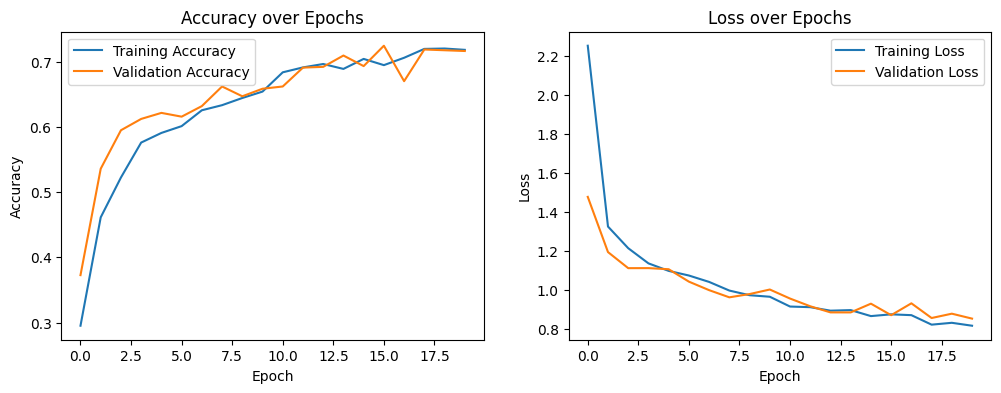

In [7]:
history = CNN_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 1st Model Iteration:
I'm starting off with a simple CNN model to make sure that we're not making it unecessarily complex.
**The model includes these layers:** 
```Python
def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(5, activation="softmax"))
    return model

model = base_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```
**Layers:**
We're including a convolutional layer aswell as a pooling layer, which helps reduce dimensions aswell as lets the model become invariant to smaller translations of the image (ex: the object in the image moves). It keeps the most important data 

We want the pooling layer after a convolutional layer since the convolutional layer is responsible for finding features like edges, textures, etc, and it makes sense to have a following pooling layer because we want the coming convolutional layers to have summarized verions of the features (a representation that maintains the most important data). The Convolutional layer also includes padding (so we don't lose data around the edges)

We're also going with Max pooling since we want to preserve the features of the images which max pooling does better than average pooling. From what I can find online, the pool_size and strides are set to a value of (2, 2) which seems to be default. 

Before the FC layer we also have a flatten layer. This is to convert a multi-dimensional array that we can send into a FC layer for classification.
We then finish off with an output layer which has 5 outputs (one for each flower kind)

**Activation functions, loss functions & optimizers:** We're starting off with ReLU for the convolutional and FC layer. This should work well since it's usually the default choice and ReLU is relatively simple, which makes it computationally efficient.

For the output layer we're going with softmax since it's the standard for multi class classification, and it pairs well with categorical_crossentropy loss function.

The optimizer I've chosen to use here is Adam, this is because it is widely used and adapted as a benchmark for deep learning papers and recommended as default. It's quick and straightfoward, aswell as adapt when adjusting learning rate for each network weight, this helps the navigation of optimization.

The main reason for using these activation functions, loss function and optimizer is because they're usually a default first choise. Exactly why this is would require a deep dive on the math side of deep learning and it can be difficult to answer why is works for our specific issue. We're not trying to reinvent the wheel here and it is prefered to use what has been shown to work, even though I can't say I fully understand it.

**Evaluation of model:**
I kept it simple for the models, meaning I included a train and validation accuracy graphs, aswell as printed out these exact values.

**Result of this model:** Checking the plots which shows train & validation accuracy aswell as loss function. We can clearly see that this simple model is horrendously overfitted with the following score: 

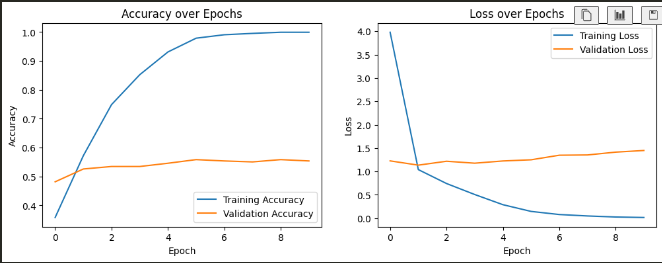

### 2nd Model Iteration:
Now I want to focus on overfitting
**The model includes these layers:**
```Python
def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"), regularizers.l2(0.01))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation="softmax"))
    return model

model = base_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

Since the model is incredibly overfitted, I want to look into tools that help preventing just this. There are a few things we've gone through during lectures that I wanna try, this includes: **Data augmentation, Regularization and Dropout.** I've also chosen to keep the activation functions, loss functions and optimizers because now I'm focusing on mainly overfitting.

I'm starting off by adding a dropout layer after our dense layer. Having dropout after the dense layer helps regularize the connections between neurons in the layers. I've chosen 30% as the dropout value, this is just to not overdo the dropout. 

I've also included l2 regularization to the Dense layer, and l2 seems to give the better scoring which will help preventing overfitting. 

**Result of this model:** The model now has clearly gotten better and is not even close in terms of overfitting as the previous version. We've gotten up to a train accuracy of **0.5742**, which is getting better, however I think we can still make it better.

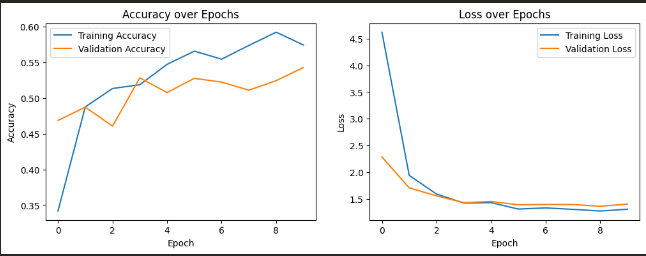

### 3rd Model Iteration:
Now that overfitting is not as much of an issue, I wanna increase the complexity of the model in order to try and increase accuracy while not overfitting the model. 

```Python
def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation="softmax"))
    return model

model = base_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```
I've added a second and third convolutional layer, but with 64 neurons for the second layer and 128 for the third layer 

**Result of this model:** Now the model seems to be slightly overfitted again, however the accuracy went up, although that might not mean anything if model overfits. I also increased the dropout from 0.3 to 0.5 which seemed to help with the overfitting.

I also tried adding batch normalization () after each convolutional layer, however the model got very overfitted and i realized that we've already normalized the data.

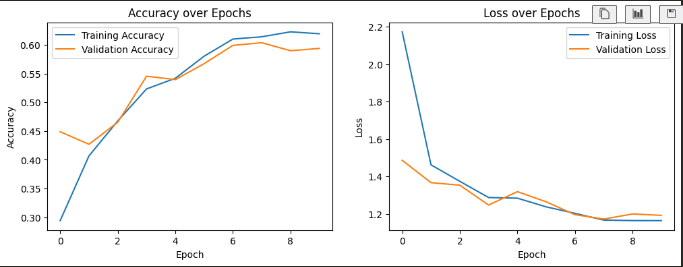

### 4th Model Iteration:

I adjusted train val split so I don't include test data that doesn't get used. So now it's a 80/20 split instead of a 70/15/15 split. I also added a simple data augmentation to test it out. Right now it doesn't increase the amount of images in the dataset, but instead augments the data on the fly instead. Perhaps looking for a way to use this in order to increase the amount of images in the dataset would be the logical next step, however, I mainly wanted to give data augmentation a try even though it's in a very simple for right now.

```Python
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(128,
                                  128,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

def base_model():
    model = Sequential()
    model.add(data_augmentation)
    
    model.add(Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation="softmax"))
    return model

model = base_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

![alt text](./3rd.png)


I also tried decreasing the amount of neurons for each convolutional layer just to make sure that I'm not making the model unecessarily complex. With this change I also again decreased Dropout rate from 0.5 to 0.3 just to check how changing dropout will affect overfitting now that the model decreased in complexity. The result from this seems to be about the same (as model above), I'm not entirely sure how the dropout rate effects computation, it seems to be the same so I'll keep it at 0.3 for now.

I'm also going to test increasing Dense layer from 128 to 256 aswell as add a 4th convolutional layer aswell as increase epochs to 20. If the result of this is just very slightly better than the model from above, then I'm going to guess that I'm getting close to getting the model as good as I can with the computational power I have.

Now the model looks like this

```Python
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(128,
                                  128,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

def base_model():
    model = Sequential()
    model.add(data_augmentation)
    
    model.add(Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation="softmax"))
    return model

model = base_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

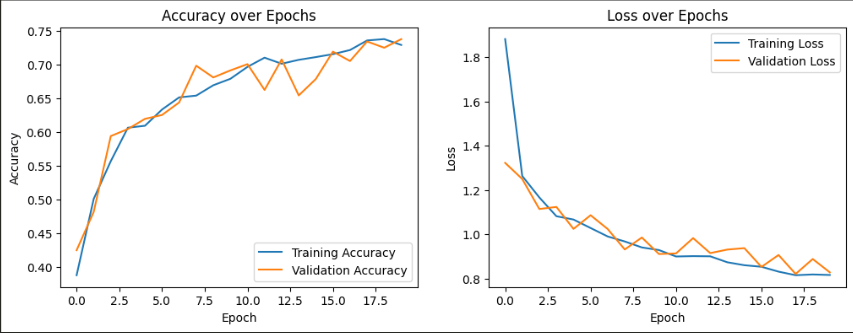

While it took a while to run the, I'm very happy with the result and glad that I tested the changes above. At this point I don't think I'm going to get the model to perform much better (unless i want to let the computer run for a week haha). 

## Summary and possible future changes

I would like to increase the complexity even more aswell as increase the amount of epochs, however that will take alot of time to test and I would preferably use something like AWS Sagemaker and use their computational power rather than my mediocre laptop. I also assumed that since it's a Kaggle dataset that it would basically be a "plug and play" kind of dataset, where data processing would be minimal. I would obviously put more time into data processing if I were to do this at work where the quality of your dataset was more ambiguous.

I feel like making smaller changes each iteration made the most sense to do, sure, it takes a while longer, but it feels like I've got more control and understand what *is* working and what is *not* working. 

There is still things like testing different hyperparameters (learning rate, epochs, optimizers, activation functions, etc. Using a tuner for this should work well), variation in data augmentation (I have what seems like quite simple data augmentation), Early stopping and so on... It would also be interesting to test how different kinds of complexity would effect the metrics. For example fewer convolutional layers, but larger amounts of neurons in each layer and vice versa. 
I also saw that a few people from our class had implemented a confusion matrix when evaluating the models, which seemed potentially very helpful. It would help your narrow down which labels the model performed either well or bad on, giving more clarity instead of just giving your a general score for all flowers. 

# VG Assignment - Transfer Learning

- Systematically identify the best hyperparameters for your network
- base TL on one of the models [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications):

**Questions to answer:**
-  **Justify your model choice**
   -  Just like we saw in the G-assignment, computational power is something important to consider in this case, so I will try to avoid unnecessarily complicated models that may work very well, but take a very long time to run. In addition, we do not have a very complicated problem with the dataset we are using, which probably means that a smaller model will work just fine for the problem we are facing. It might also be important to look at what the models are trained on in terms of images, does the training data from these models resemble the data I am using?
   - I checked the smallest version of each model to find the ones with the smallest amount of parameters to begin with. I couldn't find information about every model, but that doesn't matter since I'm mainly looking for a model with a couple millions parameters, which I have found. This is the top 5 I found.

   1. **MobileNetV3Small**: 2.5 million parameters
   2. **RegNetY002**: 3.2 million parameters
   3. **MobileNetV2**: 3.5 million parameters
   4. **MobileNet**: 4.2 million parameters
   5. **EfficientNetB0**: 5.3 million parameters

   Then I looked into what these models have been trained on and choose the model with the most similar training data to the flowers dataset.
   Based on what I can see, all of these models are trained on the ImageNet database. The database includes pictures of flowers, which is good. I, however, don't know if the models are trained on the entire database or just parts of it. Since it's hard to find this very specific information I'm going to just go for the simplest model: **MobileNetV3Small**
 
-  **Explain how you have implemented transfer learning**
   1. Transfer learning has been implemented by first importing the pre-trained model, and the model is without top layer (``include_top=True``) which means that we're not including the FC layers. This gives us way more trainable parameters for the Dense layer we create on top of the pre-trained model. From what I can find online this seems to help the pre-trained model adapt to the specific dataset we're using. I also make sure that the input shape fits the images we're using ``input_shape=(128, 128, 3)``.
   2. Then we have to freeze the pre-trained model so the weights don't get reintialized during training, meaning that the features are kept from the dataset the pre-trained model is trained on (imagenet in this case).
   3. I kept it simple and followed what was done in the transfer-learning notebook and added a flatten layer aswell as a Dense layer, and lastly I also included a dropout layer in order to deal with overfitting. I also kept the activation functions, loss function and optimizer from my earlier CNN model and I've already given reasons as to why i chose them.
   ### Model iterations:
   - For the first iteration of the transfer learning model I got a seemingly very bad score, and when i compare parameters of the transfer learning model with my model from the G-task, the transfer learning model has half the parameters in total and this *might* be the reason as to why it's performing this badly, not entirely sure just yet. I'm gonna test another pre-trained model just to make sure that I better understand why it's underperforming so badly.
      - **Results**:
         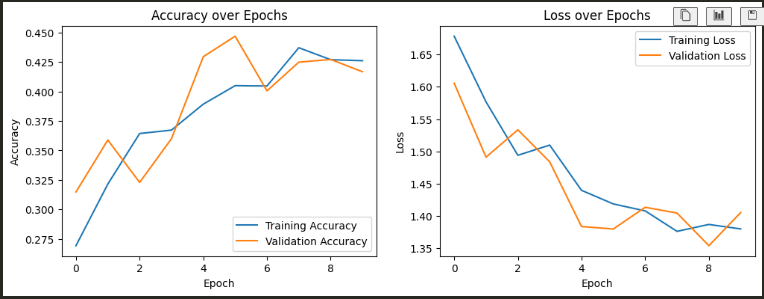 
   - Now having tested another model (VGG16 which is also trained on ImageNet) with the same setup as MobileNetV3Small, it is clear to me that the issue here was the pre-trained model. However, VGG16 has about 15 million parameters which is too much, therefo I've opted to go with a the standard MobileNet model which has about 3 million paramters (3x that of MobileNetV3Small). This is the result with MobileNet: 
      **Results**:
      - 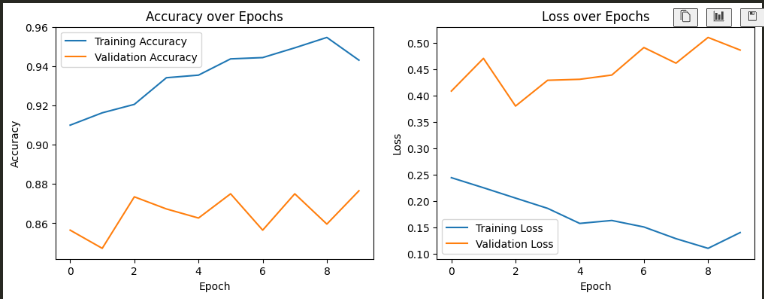
      The transfer learning model is still overfitted, however, even the validation accuracy is still quite high, and it's now better than the CNN model I created for the G-task. Next step is to add l2 regularization to the model to try and help with overfitting (this worked very well on CNN model), and this is the result:
      **Results**: 
      - 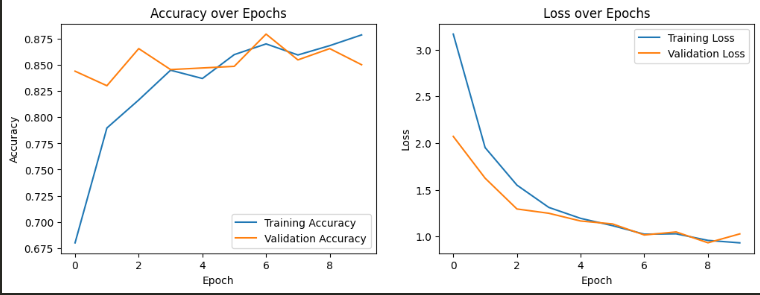
      This is a suprisingly good score and I'm quite happy with the results here. Now lets go to the hyperparameter tuning part.
          
-  **Explain how you *systematically* chose the best hyperparameters (should be apparent in the code)**
   -  I've used the Keras tuner in order to find the best hyperparameters, more specifically: the Hyperband algorithm. What's cool about this algorithm is that it uses a championship style way of finding the best hyperparameters. The idea here is that the best hyperparamters will always rise to the top and "win". The reason why using Hyperband is better than Randomsearch is this: Instead of doing a full training for values that are bad, it will instead train for a few epochs then pick the best hyperparameters based on the results from the few epochs that are run. Finally it fully trains the model with the best hyperparameters Hyperband found. This is obviously advantagious because we're on laptops and computational power is an issue. Because of this, I've opted to go with feature extraction and not use fine-tuning here, which means that if I were to have more time and power, that is the next step to try. I also didn't use GridSearch because we've used it for a notebooks before aswell as in earlier courses, and it's interesting to test something new. 
   -  Knowing that the model I've switched to is larger, I have to make a few compromises when looking for the best hyperparameters because otherwise it'll take forever to run. This means that I have few layers on-top of the pre-trained model so it doesn't take too long to train the model. Aswell as increasing the "steps" between hyperparameter values. Luckily using the keras tuner made this simple. I basically just added a min and max value, aswell as steps. It's also important to note that while doing the tasks in the Hyperparameter_tuning notebook, I noticed that adding on more FC layers did not better the model, infact the accuracy went down, which is also a reason why it's kept "simple".  
      -  **Here's part of the tuning code**: 
```Python
    num_neurons = hp.Int('num_neurons', min_value=128, max_value=256, step=128)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.4, step=0.2)
    l2_rate = hp.Float('l2_rate', min_value=0.001, max_value=0.01, step=0.005)
```
This is the result from the keras tuner: 
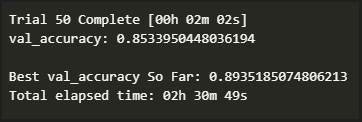

### Summary and further work:
When I began this task I managed to get the validation score to about 0.83-0.84, after using keras tuner, the result was at about 0.89 (0.87 after I train model again when creating graphs, this might be unecessary) validation accuracy. However, there is a gap between training accuarcy and the validation accuracy. I find this kind of weird since I've already applied both dropout and L2 regularization to the model which should counteract this (like it did in the G-task model).
Perhaps there is a way to get the validation accuracy and train accuracy closer to eachother, but the main thing to take away from this is that the validation score increased, which is great! So, if we're going off of validation accuracy, comparing the G-task model with the VG-task model, then it has increased from 0.73 to 0.87-0.89 validation accuracy, which is also great. I would say overall that I'm pleased with the result, and hopefully not missed anything (atleast from what I can see).

In [37]:
# train test validation split 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42)

print(X.shape)

print("Training set size:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

print("\nValidation set size:")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

print("\nTest set size:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

(4317, 128, 128, 3)
Training set size:
X_train: (3021, 128, 128, 3), y_train: (3021, 5)

Validation set size:
X_val: (648, 128, 128, 3), y_val: (648, 5)

Test set size:
X_test: (648, 128, 128, 3), y_test: (648, 5)


In [ ]:
def mobile_net_base_model(hp):
    # Load pre-trained model without top layer and freeze it
    pre_trained_mobile_net_model = MobileNet(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    pre_trained_mobile_net_model.trainable = False

    # 
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = pre_trained_mobile_net_model(inputs, training=False) # pass inputs through pre-trained model
    x = Flatten()(x) # multi dimensions to 1 dimension

    # hyperparameters to test and steps between values
    num_neurons = hp.Int('num_neurons', min_value=128, max_value=256, step=128)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.4, step=0.2)
    l2_rate = hp.Float('l2_rate', min_value=0.001, max_value=0.01, step=0.005)

    # FC layer with L2 and dropout
    x = Dense(num_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_rate))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(5, activation="softmax")(x)

    # same as earlier CNN model but with different learning rates to test
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def model_tuner():
    # creates hyperband tuner
    tuner = kt.Hyperband(mobile_net_base_model, objective='val_accuracy', max_epochs=10, hyperband_iterations=2, overwrite=True)

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    best_hyperparameters = tuner.get_best_hyperparameters()[0]
    return best_hyperparameters

best_hyperparameters = model_tuner()
# Now create the model with the best hyperparameters
model_with_best_hyperparameters = mobile_net_base_model(best_hyperparameters)

In [ ]:
epochs = 10
history = model_with_best_hyperparameters.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()